In [2]:
! git clone https://github.com/WengLab-InformaticsResearch/cohd_api.git/
# It's important to use the % for some reason
%cd ./cohd_api/notebooks
# I need to cd down to the notebooks file where the cohd_helpers are located...
# %cd notebooks

Cloning into 'cohd_api'...
remote: Enumerating objects: 2338, done.
remote: Counting objects: 100% (1012/1012), done.
remote: Compressing objects: 100% (437/437), done.
remote: Total 2338 (delta 571), reused 754 (delta 532), pack-reused 1326
Receiving objects: 100% (2338/2338), 5.40 MiB | 4.75 MiB/s, done.
Resolving deltas: 100% (1466/1466), done.
/content/cohd_api/notebooks


In [ ]:
# Upload my version of the requests modulethat has the certificate verification set to False
! cp '/content/drive/MyDrive/Jenn Take home test/cohd_requests.py' '/content/cohd_api/notebooks/cohd_helpers/cohd_requests.py'

NOTE TO SELF: Before importing I need to change the request.get(...) 
to use requests.get(..., verify=False) this is a risky way to get data but they didn't renew their security certificate... 

Also changed imported libraries won't be updated unless I delete the runtime. Restarting the runtime only changes the local variables.

In [3]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from cohd_helpers.cohd_requests import *
from cohd_helpers.cohd_temporal_analysis import *

In [4]:
# This code is to suppress the warnings due to the making a request without the updated security certificate
# https://stackoverflow.com/questions/10667960/python-requests-throwing-sslerror
# https://github.com/influxdata/influxdb-python/issues/240

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Making disease-drug dataframes stuff 

For a given disease, we survey how many times is a certain medication prescribed to the patient.




## Create the dictionary of disease and their corresponding drugs

In [5]:
# A dictionary to store all of the diseases and their drug dictionaries in a single place
diseases_dict = {}

In [6]:
RA_drugs = {}
# make a dictionary of drug types for RA
RA_drugs['tnf'] = [
    'Adalimumab', 
    'certolizumab',
    'etanercept', 
    'golimumab',
    'infliximab'
]

RA_drugs['targeted'] = [
    'Tocilizumab', 
    'sarilumab'
]

RA_drugs['jak'] = [
    'Tofacitinib', 
    'baricitinib',
    'upadacitinib'
]

# add it to the dictionary of diseases
diseases_dict['rheumatoid arthritis'] = RA_drugs

In [7]:
CD_drugs = {}
CD_drugs['tnf'] = [
    'Adalimumab', 
    'certolizumab' , 
    'infliximab'
]

CD_drugs['targeted'] = [
    'Ustekinumab', 
]

# There are no JAK inhibitors for this disease

# add it to the dictionary of diseases
diseases_dict['Crohn\'s disease'] = CD_drugs

In [8]:
UC_drugs = {}
UC_drugs['tnf'] = [
    'Adalimumab', 
    'certolizumab', 
    'golimumab', 
    'infliximab'
]
UC_drugs['targeted'] = [
    'Ustekinumab', 
]
UC_drugs['jak'] = [
    'Tofacitinib', 
]

# add it to the dictionary of diseases
diseases_dict['Ulcerative Colitis'] = UC_drugs

In [9]:
# In COHD this is called Spondylitis I think... 
AxSpa_drugs = {}

AxSpa_drugs['tnf'] = [
    'adalimumab', 
    'certolizumab', 
    'etanercept', 
    'golimumab', 
    'infliximab'
]
AxSpa_drugs['targeted'] = [
    'Secukinumab', 
    'ixekizumab'
]
AxSpa_drugs['jak'] = [
    'Tofacitinib', 
]

# add it to the dictionary of diseases
diseases_dict['Spondylitis'] = AxSpa_drugs

In [10]:
# In COHD this is called Psoriasis I think... 
PsA_drugs = {}

PsA_drugs['tnf'] = [
    'adalimumab', 
    'certolizumab', 
    'etanercept', 
    'golimumab', 
    'infliximab'
]
PsA_drugs['targeted'] = [
    'Secukinumab', 
    'ixekizumab', 
    'ustekinumab', 
    'guselkumab'
]
PsA_drugs['jak'] = [
    'Tofacitinib', 
]

# add it to the dictionary of diseases
diseases_dict['Psoriasis'] = PsA_drugs

## A method for retrieving disease-drug pair information from the COHD database

In [11]:
# returns a dataframe
def make_disease_drug_df(disease: str, drugs_dict):
    # a dictionary to store the created dataframes
    disease_drug_df = None

    for drug_type in drugs_dict.keys():
        
        ##############################################################################

        # Make an id to drug dictionary
        id_drug_dict ={}

        for drug in drugs_dict[drug_type]:
          _, id_df = find_concept(drug, domain='Drug', min_count=1, dataset_id=3)
          # I think I want it as the ingredient... that seemed to pair better with RA 
          if id_df.empty: print('Nothing found for: ' + drug)
          else:
            id_df = id_df[id_df.concept_class_id == 'Ingredient'].reset_index(drop=True)
            # get the highest value index
            id = id_df.iloc[0].concept_id
            id_drug_dict[id] = drug

        ##############################################################################

        # get the concept 1  id 
        _, id_df = find_concept(disease, domain='Condition', min_count=1, dataset_id=3)
        # I think I want the concept id to be clinical finding
        if id_df.empty: 
          print('Nothing found for: ' + disease)
          return None
        else:
          id_df = id_df[id_df.concept_class_id == 'Clinical Finding'].reset_index(drop=True)
          # get the highest value index
          concept_id_1 = id_df.iloc[0].concept_id

        ##############################################################################

        # Fetch all the disease and drug pairs with the current drug type
        # also store the dataframe for later
        df = None

        for concept_id_2 in id_drug_dict.keys():
          _, df2 = paired_concepts_frequency(concept_id_1, concept_id_2, dataset_id=3)
          df = pd.concat([df, df2]).reset_index(drop=True)

        ##############################################################################

        # Check that the current drug_type dataframe isn't empty
        if df.empty:
            print('No pairing found for: ' + disease + ' and ' + drug_type)
        else: 
            # append the datafram of this drug type

            # Replace the concept id's with the correct names
            df['concept_id_1'] = disease
            df['concept_id_2'] = df.concept_id_2.apply(lambda x: id_drug_dict[x])

            # sort the values 
            df.sort_values('concept_count', ascending=False, inplace = True)

            #add a column of the drug type
            df['drug_type'] = drug_type

            # store the df for later
            disease_drug_df = pd.concat([disease_drug_df, df]).reset_index(drop=True)
        ##############################################################################

    return disease_drug_df

# A method for creating plots of dataframes

In [23]:
def plot_disease_drug_df(disease_drug_df):

    num_drug_types = disease_drug_df.drug_type.nunique()
    disease = disease_drug_df.concept_id_1.iloc[0]

    # Plot the disease-drug dataframe
    figure, axes = plt.subplots(1, num_drug_types, figsize=(15, 5)) #, sharey=True)

    figure.suptitle(disease)

    for i, cur_drug_type in enumerate(disease_drug_df.drug_type.unique()):
        # get the relevant data
        df = disease_drug_df[disease_drug_df.drug_type==cur_drug_type]

        # Plot stuff
        cur_ax = sns.barplot(
            ax=axes[i],
            data=df, 
            x="concept_id_2",
            y="concept_count"
        )
        cur_ax.set_ylabel('Patient count')

        # rotate the x-axis labels for readbility
        cur_ax.set_xlabel(cur_drug_type + ' inhibitor')
        labels = df.concept_id_2
        cur_ax.set_xticklabels(labels, rotation=45)

    plt.show()
    figure.clf()

    # make a plot of the full dataframe

    plt.figure(figsize=(20, 5))
    sns.barplot(
        data=disease_drug_df, 
        x="concept_id_2",
        y="concept_count",
        order = disease_drug_df.sort_values('concept_count', ascending=False).concept_id_2, 
      )
    # rotate the x-axis labels for readbility
    plt.xticks(rotation=45)

    plt.title(disease)
    plt.xlabel('Inhibitors')
    plt.ylabel('Patient count')

    plt.show()
    plt.clf()

rheumatoid arthritis
Nothing found for: sarilumab
Nothing found for: baricitinib
Nothing found for: upadacitinib


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,rheumatoid arthritis,etanercept,522,0.000301,tnf
1,3,rheumatoid arthritis,Adalimumab,500,0.000289,tnf
2,3,rheumatoid arthritis,infliximab,128,0.000074,tnf
3,3,rheumatoid arthritis,golimumab,62,0.000036,tnf
4,3,rheumatoid arthritis,certolizumab,60,0.000035,tnf
5,3,rheumatoid arthritis,Tocilizumab,111,0.000064,targeted
6,3,rheumatoid arthritis,Tofacitinib,164,0.000095,jak


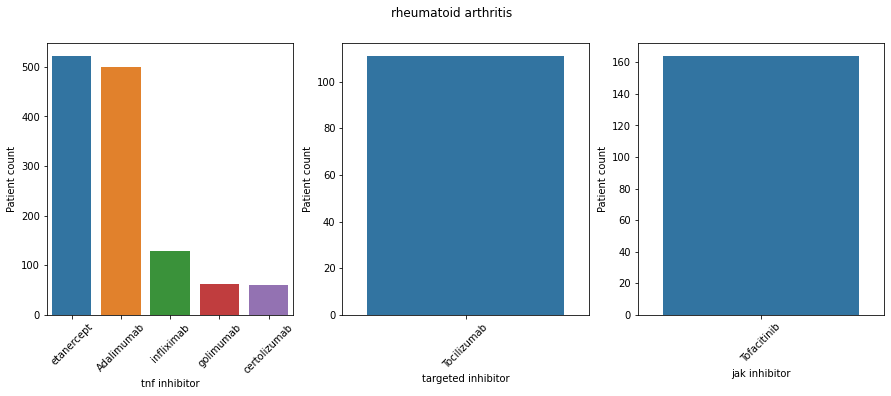

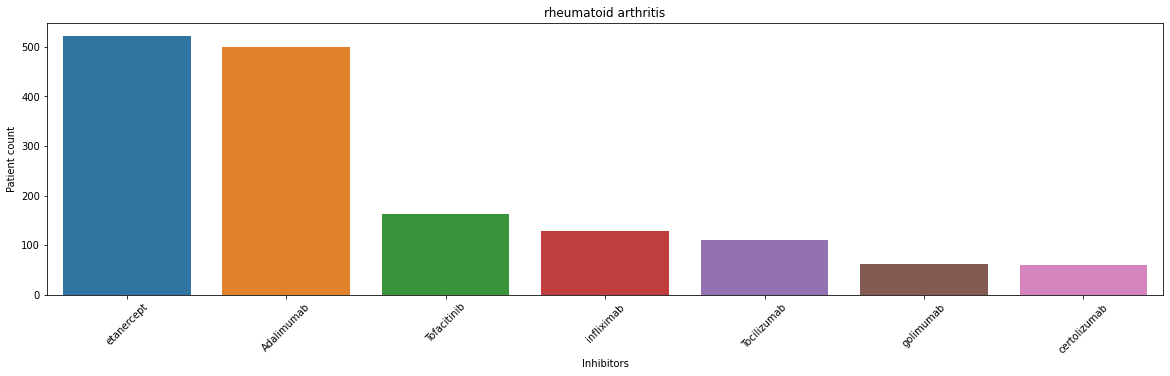

Crohn's disease


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,Crohn's disease,Adalimumab,388,0.000224,tnf
1,3,Crohn's disease,infliximab,318,0.000184,tnf
2,3,Crohn's disease,certolizumab,43,0.000025,tnf
3,3,Crohn's disease,Ustekinumab,39,0.000023,targeted


<Figure size 432x288 with 0 Axes>

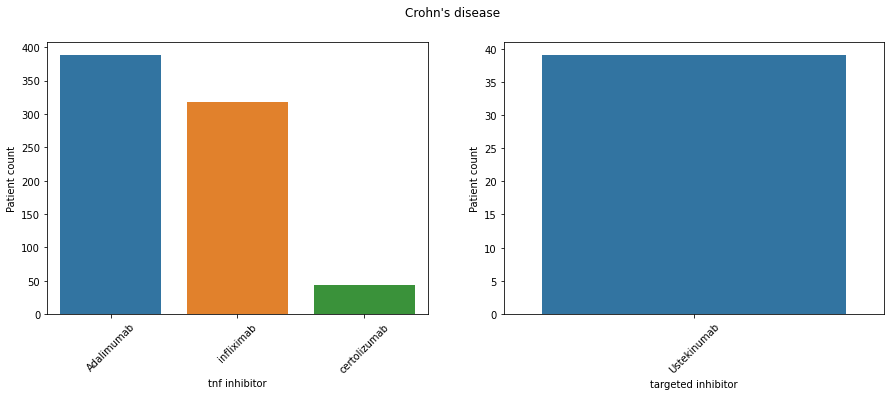

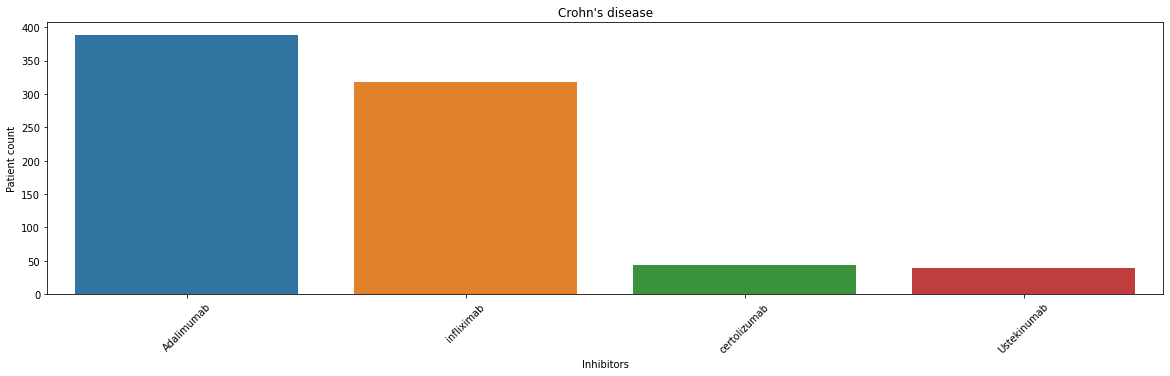

Ulcerative Colitis
No pairing found for: Ulcerative Colitis and jak


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,Ulcerative Colitis,Adalimumab,194,0.000112,tnf
1,3,Ulcerative Colitis,infliximab,194,0.000112,tnf
2,3,Ulcerative Colitis,golimumab,23,0.000013,tnf
3,3,Ulcerative Colitis,certolizumab,9,0.000005,tnf
4,3,Ulcerative Colitis,Ustekinumab,16,0.000009,targeted


<Figure size 432x288 with 0 Axes>

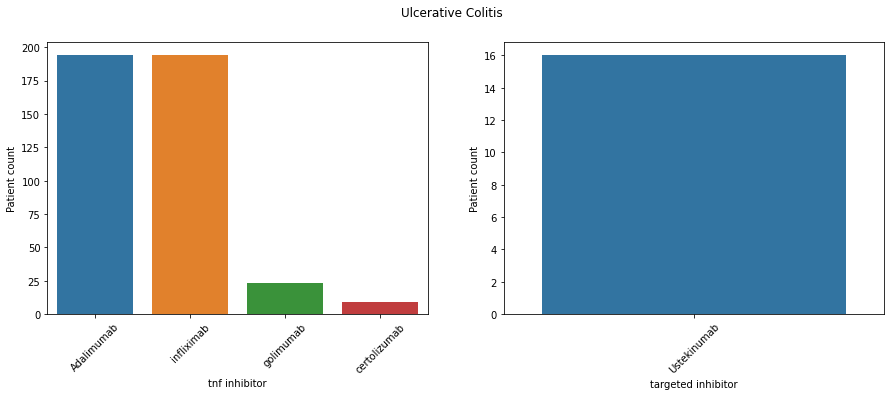

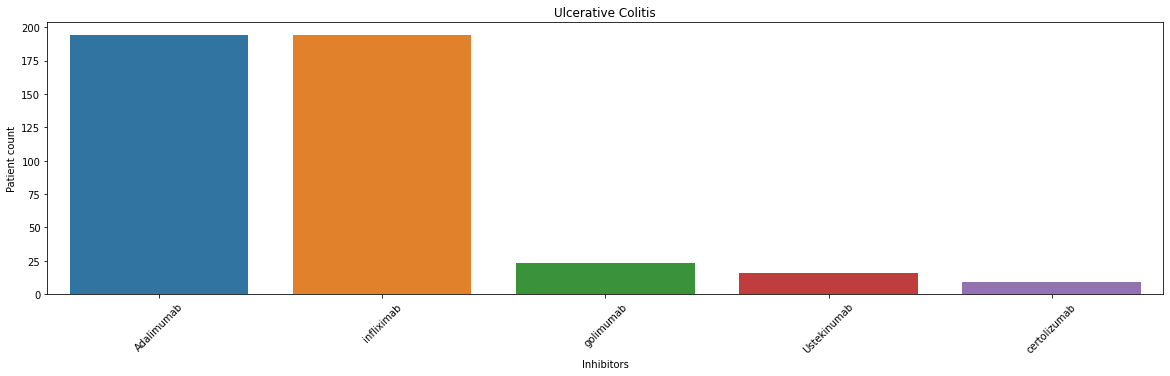

Spondylitis
No pairing found for: Spondylitis and jak


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,Spondylitis,adalimumab,105,0.000061,tnf
1,3,Spondylitis,etanercept,79,0.000046,tnf
2,3,Spondylitis,infliximab,21,0.000012,tnf
3,3,Spondylitis,golimumab,13,0.000008,tnf
4,3,Spondylitis,Secukinumab,22,0.000013,targeted


<Figure size 432x288 with 0 Axes>

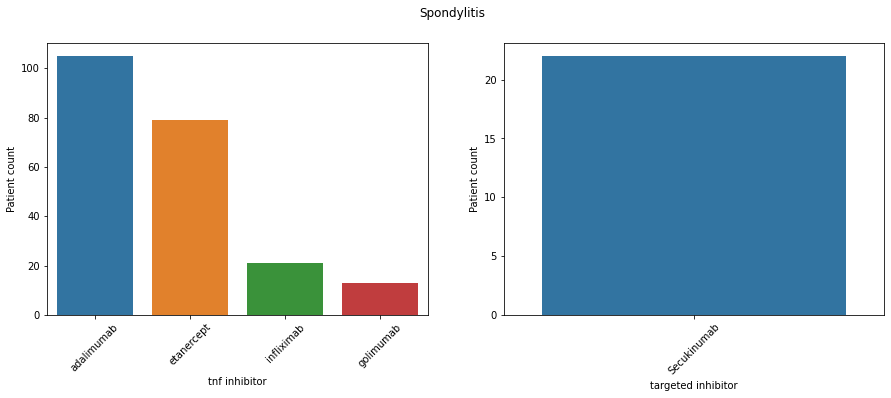

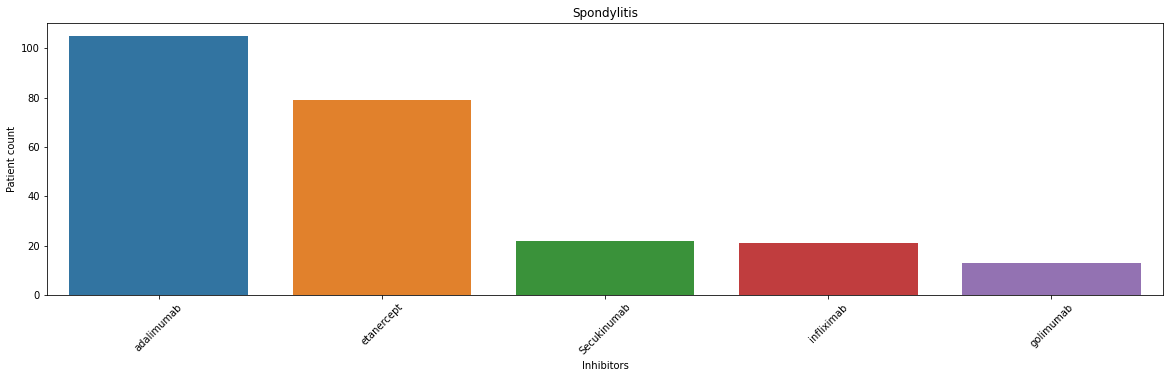

Psoriasis
Nothing found for: guselkumab


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,Psoriasis,adalimumab,490,0.000283,tnf
1,3,Psoriasis,etanercept,427,0.000247,tnf
2,3,Psoriasis,infliximab,86,0.000050,tnf
3,3,Psoriasis,golimumab,34,0.000020,tnf
4,3,Psoriasis,certolizumab,27,0.000016,tnf
5,3,Psoriasis,ustekinumab,287,0.000166,targeted
6,3,Psoriasis,Secukinumab,80,0.000046,targeted
7,3,Psoriasis,ixekizumab,35,0.000020,targeted
8,3,Psoriasis,Tofacitinib,25,0.000014,jak


<Figure size 432x288 with 0 Axes>

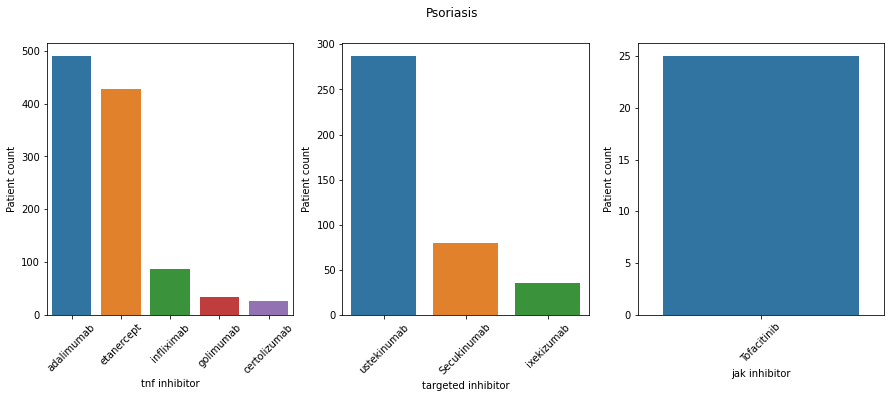

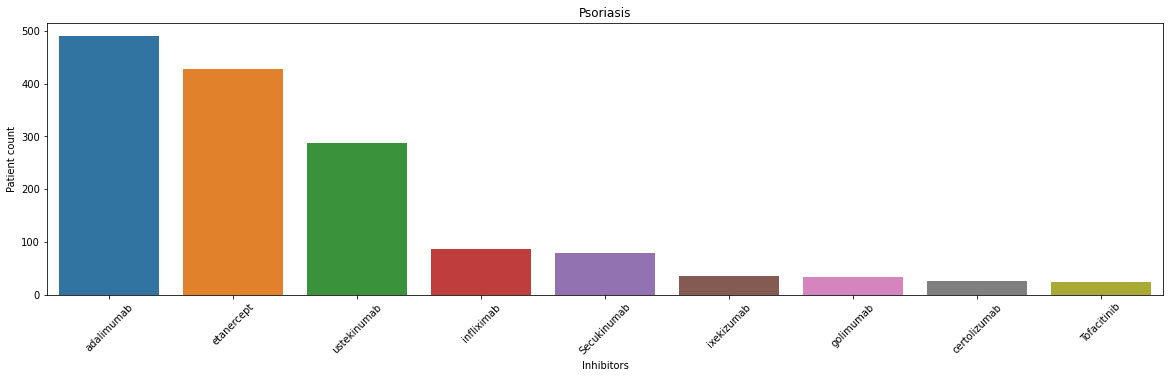

<Figure size 432x288 with 0 Axes>

In [14]:
# Try looping over all of the drugs
for disease, drug_dict in diseases_dict.items():
    print(disease)
    disease_drug_df = make_disease_drug_df(disease, drug_dict)
    display(disease_drug_df)
    plot_disease_drug_df(disease_drug_df)


# Methotrexate to other Rheumatoid Arthitis drugs comparison

## Create a dictionary of the Rheumatoid Arthitis drugs

In [15]:
drug_to_drugs_dict = {}

In [16]:
metho_drugs = {}
# make a dictionary of drug types for RA
metho_drugs['tnf'] = [
    'Adalimumab', 
    'certolizumab',
    'etanercept', 
    'golimumab',
    'infliximab'
]

metho_drugs['targeted'] = [
    'Tocilizumab', 
    'sarilumab'
]

metho_drugs['jak'] = [
    'Tofacitinib', 
    'baricitinib',
    'upadacitinib'
]

# add it to the dictionary of diseases
drug_to_drugs_dict['Methotrexate'] = metho_drugs

## A method for retrieving the methotrexate-drug comparisons

This code is nearly identical to the method for retrieving disease-drug comparisons however in the cases of getting drug-drug data a couple additional checks need to be done to be sure that the retrieved dataset is clean/tidy.

In [17]:
# returns a dataframe
def make_drug_drug_df(disease: str, drugs_dict):
    # a dictionary to store the created dataframes
    disease_drug_df = None

    for drug_type in drugs_dict.keys():
        
        ##############################################################################

        # Make an id to drug dictionary
        id_drug_dict ={}

        for drug in drugs_dict[drug_type]:
          _, id_df = find_concept(drug, domain='Drug', min_count=1, dataset_id=3)
          # I think I want it as the ingredient... that seemed to pair better with RA 
          if id_df.empty: print('Nothing found for: ' + drug)
          else:
            id_df = id_df[id_df.concept_class_id == 'Ingredient'].reset_index(drop=True)
            # get the highest value index
            id = id_df.iloc[0].concept_id
            id_drug_dict[id] = drug

        ##############################################################################

        # get the concept 1  id 
        _, id_df = find_concept(disease, domain='Drug', min_count=1, dataset_id=3)
        # I think I want the concept id to be clinical finding
        if id_df.empty: 
          print('Nothing found for: ' + disease)
          return None
        else:
          id_df = id_df[id_df.concept_class_id == 'Ingredient'].reset_index(drop=True)
          # get the highest value index
          concept_id_1 = id_df.concept_id.iloc[0]
        
        ##############################################################################

        # Fetch all the disease and drug pairs with the current drug type
        # also store the dataframe for later
        df = None

        for concept_id_2 in id_drug_dict.keys():
          _, df2 = paired_concepts_frequency(concept_id_1, concept_id_2, dataset_id=3)
          df = pd.concat([df, df2]).reset_index(drop=True)

        ##############################################################################

        # Check that the current drug_type dataframe isn't empty
        if df.empty:
            print('No pairing found for: ' + disease + ' and ' + drug_type)
        else: 
            # when doing the drug-drug pairing, sometimes the concept 1 and concept 2 ids will be switched around
            df['temp_name'] = df.apply(
                lambda row: int(row['concept_id_1']) if row['concept_id_2'] == concept_id_1 else int(row['concept_id_2']), 
                axis=1)
            df['concept_id_2'] = df['temp_name']
            df.drop(['temp_name'], axis=1, inplace=True)

            # append the dataframe of this drug type
            # Replace the concept id's with the correct names
            df['concept_id_1'] = disease
            df['concept_id_2'] = df.concept_id_2.apply(lambda x: id_drug_dict[x])

            # sort the values 
            df.sort_values('concept_count', ascending=False, inplace = True)

            #add a column of the drug type
            df['drug_type'] = drug_type

            # store the df for later
            disease_drug_df = pd.concat([disease_drug_df, df]).reset_index(drop=True)
        ##############################################################################

    return disease_drug_df

## Display the methotrexate data

In [21]:
drug_drug_df = make_drug_drug_df('Methotrexate', metho_drugs)
display(drug_drug_df)

Nothing found for: sarilumab
Nothing found for: baricitinib
Nothing found for: upadacitinib


,dataset_id,concept_id_1,concept_id_2,concept_count,concept_frequency,drug_type
0,3,Methotrexate,Adalimumab,737,0.000426,tnf
1,3,Methotrexate,etanercept,576,0.000333,tnf
2,3,Methotrexate,infliximab,255,0.000147,tnf
3,3,Methotrexate,certolizumab,85,0.000049,tnf
4,3,Methotrexate,golimumab,83,0.000048,tnf
5,3,Methotrexate,Tocilizumab,99,0.000057,targeted
6,3,Methotrexate,Tofacitinib,125,0.000072,jak


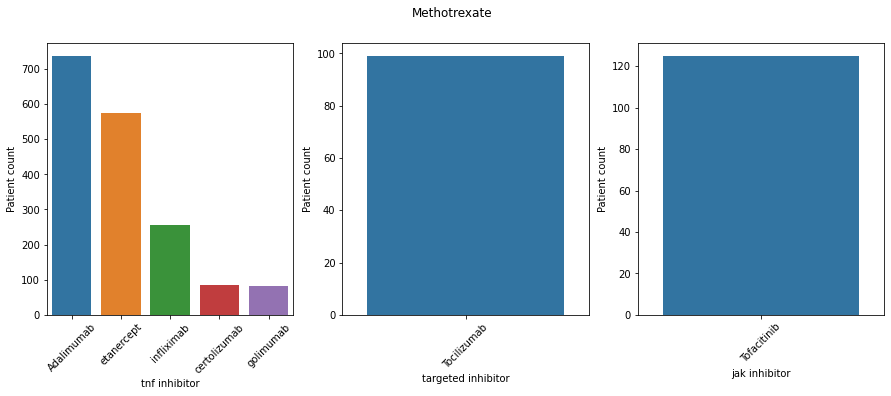

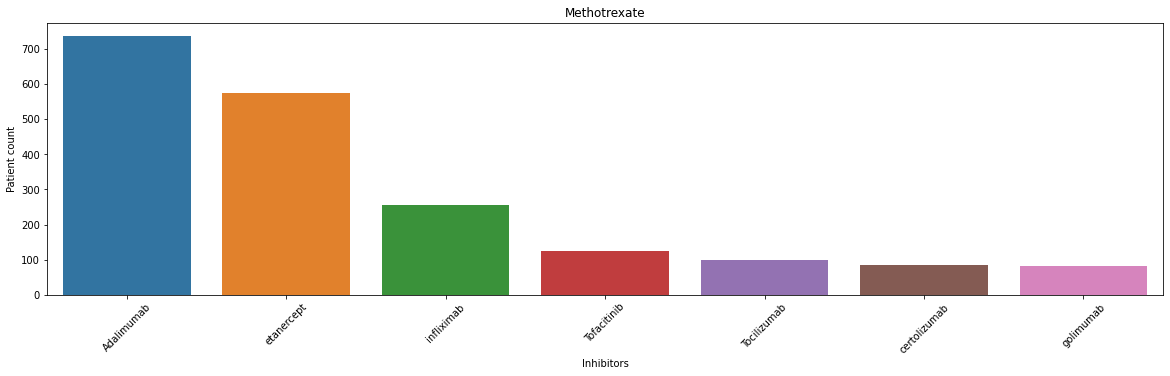

<Figure size 432x288 with 0 Axes>

In [22]:
plot_disease_drug_df(drug_drug_df)